# Análisis de Redes Sociales - Reddit

Análisis simple de interacciones en subreddits latinoamericanos.

**Objetivo**: Crear una red de usuarios que se responden entre sí y analizar influencia.

## 1. Instalación de librerías

In [14]:
%pip install pandas networkx matplotlib praw python-dotenv wordcloud seaborn textblob scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/624.3 kB ? eta -:--:--Downloading textblob-0.19.0-py3-none-any.whl (624 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 2.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━ 0.6/1.5 MB 18.9 MB/s eta 0:00:01Downloading nltk-3.9.1-py3-none-any.whl (1.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.4 MB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.4 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notic

## 2. Configuración

In [2]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import praw
from datetime import datetime

# Cargar credenciales
load_dotenv()

# Configurar Reddit API
reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"), 
    user_agent="analisis-redes/1.0"
)

print("✅ Configuración completada")

✅ Configuración completada


## 3. Descarga de datos

In [8]:
# Configuración
SUBREDDITS = ["argentina", "bolivia", "peru"]
POSTS_POR_SUB = 20

# Crear carpeta data
os.makedirs("data", exist_ok=True)

print("🚀 Descargando datos con texto de comentarios...")

rows = []

for sub_name in SUBREDDITS:
    print(f"\n📂 r/{sub_name}")
    
    subreddit = reddit.subreddit(sub_name)
    posts = list(subreddit.hot(limit=POSTS_POR_SUB))
    
    for i, post in enumerate(posts, 1):
        print(f"  [{i}/{len(posts)}] {post.title[:40]}...")
        
        # Obtener comentarios
        post.comments.replace_more(limit=2)
        comments = post.comments.list()
        
        for comment in comments:
            if comment.author is None:
                continue
                
            # Determinar si es respuesta a otro usuario
            reply_to = None
            parent_type = "post"  # Por defecto responde al post
            
            if not comment.is_root:
                try:
                    parent = comment.parent()
                    if hasattr(parent, 'author') and parent.author:
                        reply_to = str(parent.author)
                        parent_type = "comment"
                except:
                    pass
            
            # Obtener texto del comentario (limitado para no saturar)
            comment_text = str(comment.body)[:500] if hasattr(comment, 'body') else ""
            
            rows.append({
                "subreddit": sub_name,
                "post_id": post.id,
                "post_title": post.title[:100],
                "comment_id": comment.id,
                "author": str(comment.author),
                "reply_to": reply_to,
                "parent_type": parent_type,
                "is_root": comment.is_root,
                "comment_text": comment_text,
                "score": comment.score,
                "created_utc": comment.created_utc
            })

# Crear DataFrame
df = pd.DataFrame(rows)

# Guardar datos
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"data/reddit_completo_{timestamp}.csv"
df.to_csv(filename, index=False)

print(f"\n✅ Descarga completada:")
print(f"   • Total comentarios: {len(df)}")
print(f"   • Usuarios únicos: {df['author'].nunique()}")
print(f"   • Respuestas a usuarios: {df[df['parent_type'] == 'comment']['reply_to'].notna().sum()}")
print(f"   • Comentarios con texto: {df['comment_text'].str.len().gt(0).sum()}")
print(f"   • Archivo: {filename}")

# Mostrar distribución por subreddit
print(f"\n📊 Distribución por subreddit:")
for sub in SUBREDDITS:
    count = len(df[df['subreddit'] == sub])
    print(f"   • r/{sub}: {count} comentarios")

df.head()

🚀 Descargando datos con texto de comentarios...

📂 r/argentina
  [1/20] Thread Diario de Dudas, Consultas y Mita...
  [1/20] Thread Diario de Dudas, Consultas y Mita...
  [2/20] Viernes de llego el finde...
  [2/20] Viernes de llego el finde...
  [3/20] Usaban ChatGPT para hacer la web del VET...
  [3/20] Usaban ChatGPT para hacer la web del VET...
  [4/20] Son de terror...
  [4/20] Son de terror...
  [5/20] Uno quiere entrar al campus virtual a cu...
  [5/20] Uno quiere entrar al campus virtual a cu...
  [6/20] Juzgamos mal al capitán Beto: Alberto Fe...
  [6/20] Juzgamos mal al capitán Beto: Alberto Fe...
  [7/20] La actriz de "Bordeaux" en Peacemaker es...
  [7/20] La actriz de "Bordeaux" en Peacemaker es...
  [8/20] Vayan a fiscalizar como en el balotaje d...
  [8/20] Vayan a fiscalizar como en el balotaje d...
  [9/20] Mira ese conocimiento de ingles...
  [9/20] Mira ese conocimiento de ingles...
  [10/20] Se le cayó el perro en el lago de la res...
  [10/20] Se le cayó el perro e

,subreddit,post_id,post_title,comment_id,author,reply_to,parent_type,is_root,comment_text,score,created_utc
0,argentina,1ney5nq,"Thread Diario de Dudas, Consultas y Mitaps - 1...",ndsppxb,gorditololero,None,post,True,cafe 1 de N,2,1.757676e+09
1,argentina,1ney5nq,"Thread Diario de Dudas, Consultas y Mitaps - 1...",ndu1rdl,Background_Let_340,None,post,True,Algún transportista para personas con discapac...,2,1.757692e+09
2,argentina,1ney5nq,"Thread Diario de Dudas, Consultas y Mitaps - 1...",ndvt1w9,United_Focus7742,None,post,True,"Sei de la tarde y 23 comentarios, que miseria,...",2,1.757710e+09
3,argentina,1ney5nq,"Thread Diario de Dudas, Consultas y Mitaps - 1...",ndt6ec8,el_chatarrero,None,post,True,Mi teoría sobre los call centers y bots pagos ...,3,1.757682e+09
4,argentina,1ney5nq,"Thread Diario de Dudas, Consultas y Mitaps - 1...",ndu71fj,A77ak,None,post,True,Las compras por Temu tienen limite? Se paga im...,1,1.757693e+09


## 4. Construcción de la red

In [9]:
# Análisis separado por subreddit
print("🔗 Construyendo redes por subreddit:")

# Solo respuestas a otros usuarios (no al post)
respuestas_usuarios = df[df['parent_type'] == 'comment'].copy()

print(f"\n📊 Resumen general:")
print(f"   • Total comentarios: {len(df)}")
print(f"   • Respuestas entre usuarios: {len(respuestas_usuarios)}")

# Crear grafos por subreddit
grafos = {}
estadisticas = {}

for sub in SUBREDDITS:
    print(f"\n📂 r/{sub}:")
    
    # Filtrar datos del subreddit
    sub_data = respuestas_usuarios[respuestas_usuarios['subreddit'] == sub]
    
    if len(sub_data) == 0:
        print(f"   ❌ Sin respuestas entre usuarios")
        grafos[sub] = None
        estadisticas[sub] = None
        continue
    
    # Contar interacciones
    edges = sub_data.groupby(['author', 'reply_to']).agg({
        'comment_id': 'count',
        'score': 'mean'
    }).rename(columns={'comment_id': 'peso', 'score': 'score_promedio'}).reset_index()
    
    # Crear grafo dirigido
    G = nx.DiGraph()
    for _, row in edges.iterrows():
        G.add_edge(row['author'], row['reply_to'], 
                  weight=row['peso'], 
                  avg_score=row['score_promedio'])
    
    grafos[sub] = G
    
    # Estadísticas
    stats = {
        'usuarios': len(G.nodes()),
        'conexiones': len(G.edges()),
        'densidad': nx.density(G),
        'componentes': nx.number_weakly_connected_components(G),
        'componente_gigante': len(max(nx.weakly_connected_components(G), key=len)) if len(G) > 0 else 0
    }
    estadisticas[sub] = stats
    
    print(f"   • Usuarios: {stats['usuarios']}")
    print(f"   • Conexiones: {stats['conexiones']}")
    print(f"   • Densidad: {stats['densidad']:.4f}")
    print(f"   • Componentes: {stats['componentes']}")
    print(f"   • Componente gigante: {stats['componente_gigante']} usuarios")

# Resumen comparativo
print(f"\n📈 Comparación entre subreddits:")
comparison_df = pd.DataFrame(estadisticas).T
print(comparison_df)

🔗 Construyendo redes por subreddit:

📊 Resumen general:
   • Total comentarios: 2442
   • Respuestas entre usuarios: 1310

📂 r/argentina:
   • Usuarios: 609
   • Conexiones: 916
   • Densidad: 0.0025
   • Componentes: 29
   • Componente gigante: 533 usuarios

📂 r/bolivia:
   • Usuarios: 119
   • Conexiones: 153
   • Densidad: 0.0109
   • Componentes: 9
   • Componente gigante: 80 usuarios

📂 r/peru:
   • Usuarios: 68
   • Conexiones: 67
   • Densidad: 0.0147
   • Componentes: 13
   • Componente gigante: 17 usuarios

📈 Comparación entre subreddits:
           usuarios  conexiones  densidad  componentes  componente_gigante
argentina     609.0       916.0  0.002474         29.0               533.0
bolivia       119.0       153.0  0.010896          9.0                80.0
peru           68.0        67.0  0.014706         13.0                17.0


## 5. Análisis de centralidades

In [10]:
# Análisis de centralidades y comunidades por subreddit
print("🏆 Análisis de influencia por subreddit:")

rankings = {}
comunidades_info = {}

for sub in SUBREDDITS:
    print(f"\n📂 r/{sub}:")
    
    G = grafos[sub]
    if G is None or len(G.nodes()) == 0:
        print(f"   ❌ Sin red para analizar")
        rankings[sub] = None
        comunidades_info[sub] = None
        continue
    
    # Centralidades
    in_degree = nx.in_degree_centrality(G)
    pagerank = nx.pagerank(G, weight='weight')
    betweenness = nx.betweenness_centrality(G, weight='weight')
    
    # Ranking
    ranking = pd.DataFrame({
        'usuario': list(G.nodes()),
        'in_degree': [in_degree[n] for n in G.nodes()],
        'pagerank': [pagerank[n] for n in G.nodes()],
        'betweenness': [betweenness[n] for n in G.nodes()]
    }).sort_values('pagerank', ascending=False)
    
    rankings[sub] = ranking
    
    print(f"   🥇 Top 3 usuarios más influyentes:")
    for i, (_, row) in enumerate(ranking.head(3).iterrows(), 1):
        print(f"      {i}. {row['usuario']} (PageRank: {row['pagerank']:.4f})")
    
    # Detección de comunidades (convertir a no dirigido)
    if len(G.nodes()) > 2:
        UG = G.to_undirected()
        
        # Eliminar self-loops si existen
        UG.remove_edges_from(nx.selfloop_edges(UG))
        
        if len(UG.edges()) > 0:
            from networkx.algorithms.community import louvain_communities
            from networkx.algorithms.community.quality import modularity
            
            comunidades = louvain_communities(UG, weight='weight', seed=42)
            Q = modularity(UG, comunidades, weight='weight')
            
            comunidades_info[sub] = {
                'comunidades': comunidades,
                'modularidad': Q,
                'num_comunidades': len(comunidades),
                'tamaños': [len(c) for c in comunidades]
            }
            
            print(f"   🏘️  Comunidades: {len(comunidades)} (Q = {Q:.3f})")
            print(f"   📊 Tamaños: {sorted([len(c) for c in comunidades], reverse=True)[:5]}")
        else:
            print(f"   ⚠️ Sin aristas para detectar comunidades")
            comunidades_info[sub] = None
    else:
        print(f"   ⚠️ Red muy pequeña para detectar comunidades")
        comunidades_info[sub] = None

🏆 Análisis de influencia por subreddit:

📂 r/argentina:
   🥇 Top 3 usuarios más influyentes:
      1. TheBuri (PageRank: 0.0205)
      2. MrArgon01 (PageRank: 0.0196)
      3. Azulejoforestal (PageRank: 0.0164)
   🏘️  Comunidades: 46 (Q = 0.796)
   📊 Tamaños: [48, 44, 41, 40, 38]

📂 r/bolivia:
   🥇 Top 3 usuarios más influyentes:
      1. mimesota (PageRank: 0.0678)
      2. Dismal-Educator6994 (PageRank: 0.0419)
      3. MateoOPe (PageRank: 0.0383)
   🏘️  Comunidades: 16 (Q = 0.785)
   📊 Tamaños: [20, 13, 12, 11, 10]

📂 r/peru:
   🥇 Top 3 usuarios más influyentes:
      1. No-Tumbleweed2126 (PageRank: 0.1075)
      2. Worried-Lawyer-9773 (PageRank: 0.0954)
      3. LordHawkman (PageRank: 0.0519)
   🏘️  Comunidades: 15 (Q = 0.857)
   📊 Tamaños: [11, 10, 6, 6, 5]
   🏘️  Comunidades: 46 (Q = 0.796)
   📊 Tamaños: [48, 44, 41, 40, 38]

📂 r/bolivia:
   🥇 Top 3 usuarios más influyentes:
      1. mimesota (PageRank: 0.0678)
      2. Dismal-Educator6994 (PageRank: 0.0419)
      3. MateoOPe (Pa

## 6. Visualización

📊 Generando visualizaciones por subreddit:


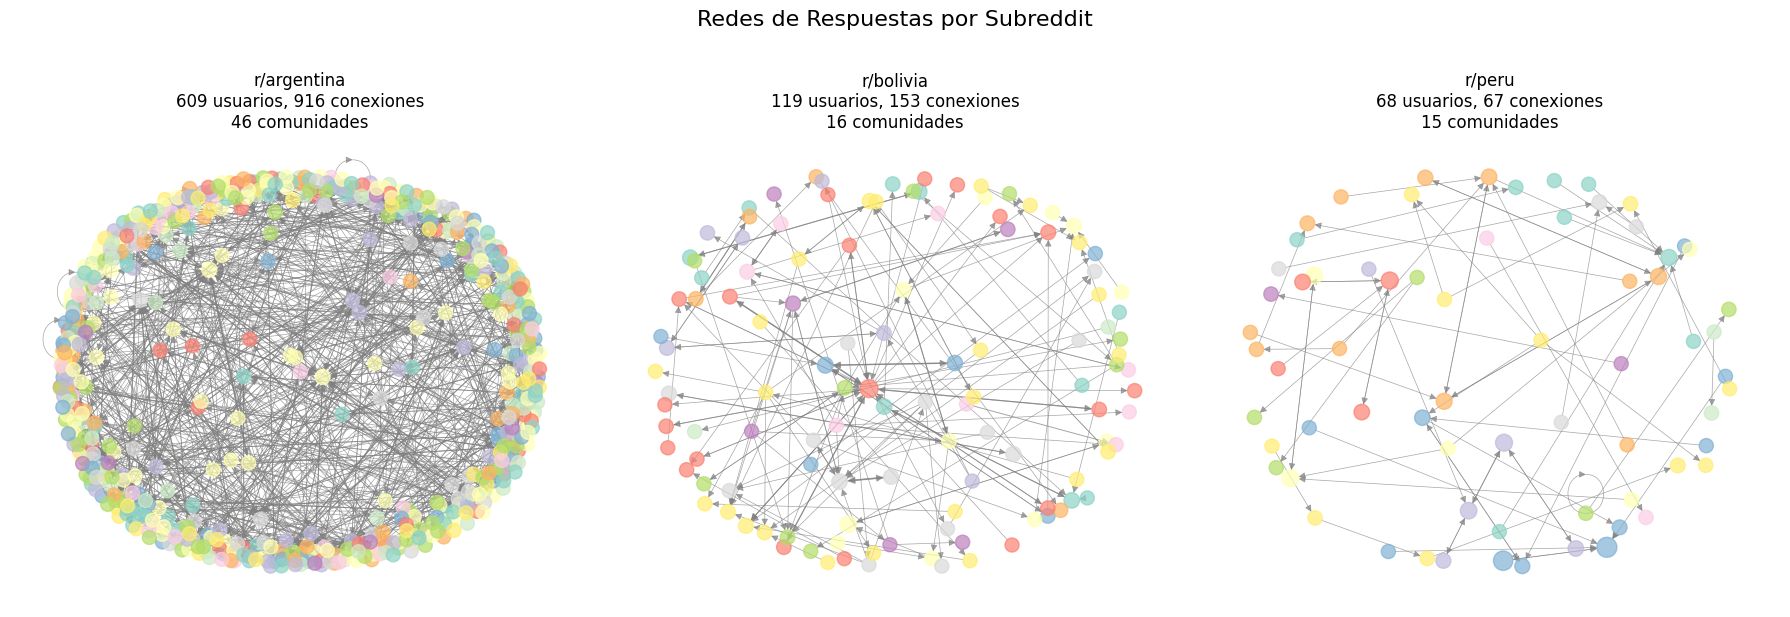


📈 Resumen estadístico:

r/argentina:
   • Red: 609 usuarios, 916 conexiones
   • Densidad: 0.0025
   • Componente gigante: 533 usuarios
   • Comunidades: 46 (Q = 0.796)
   • Tamaños: [48, 44, 41]
   • Más influyente: TheBuri (PageRank: 0.0205)

r/bolivia:
   • Red: 119 usuarios, 153 conexiones
   • Densidad: 0.0109
   • Componente gigante: 80 usuarios
   • Comunidades: 16 (Q = 0.785)
   • Tamaños: [20, 13, 12]
   • Más influyente: mimesota (PageRank: 0.0678)

r/peru:
   • Red: 68 usuarios, 67 conexiones
   • Densidad: 0.0147
   • Componente gigante: 17 usuarios
   • Comunidades: 15 (Q = 0.857)
   • Tamaños: [11, 10, 6]
   • Más influyente: No-Tumbleweed2126 (PageRank: 0.1075)


In [11]:
# Visualizaciones separadas por subreddit
import numpy as np

print("📊 Generando visualizaciones por subreddit:")

# Configurar subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Redes de Respuestas por Subreddit', fontsize=16, y=1.02)

for idx, sub in enumerate(SUBREDDITS):
    ax = axes[idx]
    G = grafos[sub]
    
    if G is None or len(G.nodes()) < 2:
        ax.text(0.5, 0.5, f'r/{sub}\nSin red\nsuficiente', 
                ha='center', va='center', fontsize=14)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title(f'r/{sub}')
        ax.axis('off')
        continue
    
    # Layout para este grafo
    pos = nx.spring_layout(G, seed=42, k=1, iterations=50)
    
    # Tamaños de nodos basados en PageRank
    ranking = rankings[sub]
    if ranking is not None and len(ranking) > 0:
        sizes = []
        for node in G.nodes():
            pr = ranking[ranking['usuario'] == node]['pagerank']
            if len(pr) > 0:
                size = 1000 * pr.iloc[0] + 100
            else:
                size = 200
            sizes.append(size)
    else:
        sizes = [300] * len(G.nodes())
    
    # Colores por comunidades si existen
    node_colors = ['lightblue'] * len(G.nodes())
    if comunidades_info[sub] is not None:
        communities = comunidades_info[sub]['comunidades']
        colors = plt.cm.Set3(np.linspace(0, 1, len(communities)))
        node_list = list(G.nodes())
        
        for i, community in enumerate(communities):
            for node in community:
                if node in node_list:
                    node_colors[node_list.index(node)] = colors[i]
    
    # Grosor de aristas
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    edge_widths = [np.sqrt(w) * 0.5 for w in edge_weights]
    
    # Dibujar red
    nx.draw_networkx(
        G, pos, ax=ax,
        node_size=sizes,
        node_color=node_colors,
        edge_color='gray',
        width=edge_widths,
        with_labels=False,
        alpha=0.7
    )
    
    # Título con estadísticas
    stats = estadisticas[sub]
    title = f"r/{sub}\n{stats['usuarios']} usuarios, {stats['conexiones']} conexiones"
    if comunidades_info[sub] is not None:
        title += f"\n{comunidades_info[sub]['num_comunidades']} comunidades"
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Mostrar estadísticas detalladas
print(f"\n📈 Resumen estadístico:")
for sub in SUBREDDITS:
    if estadisticas[sub] is not None:
        stats = estadisticas[sub]
        print(f"\nr/{sub}:")
        print(f"   • Red: {stats['usuarios']} usuarios, {stats['conexiones']} conexiones")
        print(f"   • Densidad: {stats['densidad']:.4f}")
        print(f"   • Componente gigante: {stats['componente_gigante']} usuarios")
        
        if comunidades_info[sub] is not None:
            com_info = comunidades_info[sub]
            print(f"   • Comunidades: {com_info['num_comunidades']} (Q = {com_info['modularidad']:.3f})")
            print(f"   • Tamaños: {sorted(com_info['tamaños'], reverse=True)[:3]}")
        
        if rankings[sub] is not None:
            top_user = rankings[sub].iloc[0]
            print(f"   • Más influyente: {top_user['usuario']} (PageRank: {top_user['pagerank']:.4f})")